In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import splitfolders

splitfolders.ratio(
    "/content/gdrive/My Drive/data/all",
    "./data/split_folder",
    seed=21,
    ratio=(0.8, 0.1, 0.1),
    group_prefix=None
)

Copying files: 14700 files [09:54, 24.71 files/s] 


In [4]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Conv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

In [5]:
train_dir = "./data/split_folder/train"
val_dir = "./data/split_folder/val"
test_dir = "./data/split_folder/test"
height = 450
width = 450
batch_size = 32

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=21,
    image_size=(width, height),
    batch_size=batch_size
)


Found 11760 files belonging to 2 classes.


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=21,
    image_size=(width, height),
    batch_size=batch_size
)

Found 1469 files belonging to 2 classes.


In [7]:
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=21,
    image_size=(width, height),
    batch_size=batch_size
)

Found 1471 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names

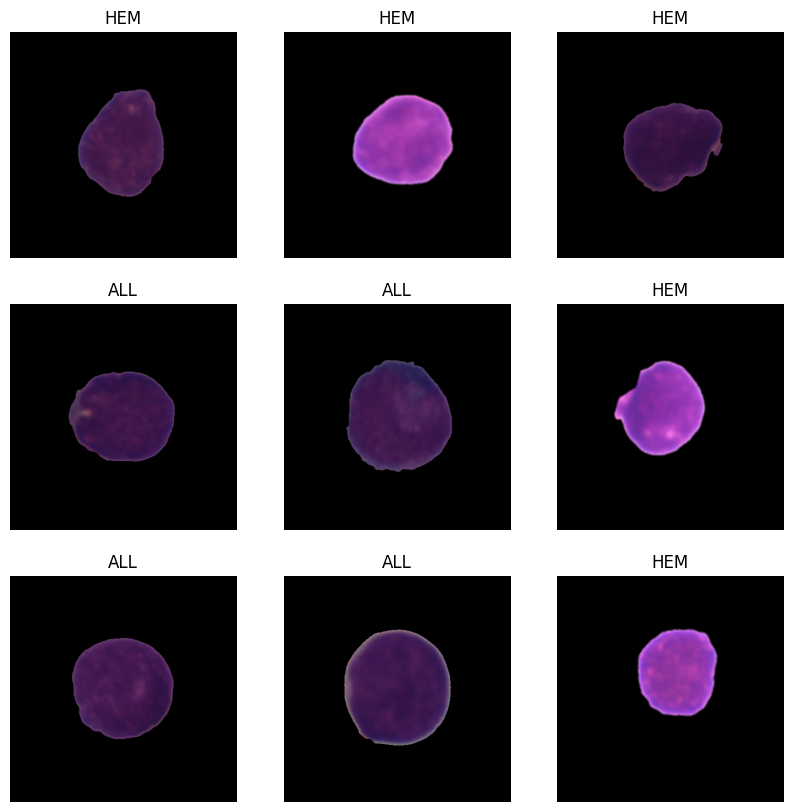

In [9]:
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(450,450,3)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(3, padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(3, padding='same'))
model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3, padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3, padding='same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 450, 450, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 450, 450, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 256)     147712    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 384)       8

In [11]:
optimizer = RMSprop()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [12]:
filepath = "weights.best.50epochs_rms.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
epochs = 50

history = model.fit(
    train_data,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_data,
    shuffle=True,
    callbacks=callbacks_list
)

Epoch 1/50
368/368 [==============================] - ETA: 0s - loss: 4.8450 - accuracy: 0.7673
Epoch 1: val_accuracy improved from -inf to 0.81824, saving model to weights.best.50epochs_rms.hdf5
368/368 [==============================] - 216s 529ms/step - loss: 4.8450 - accuracy: 0.7673 - val_loss: 0.4679 - val_accuracy: 0.8182
Epoch 2/50
368/368 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.8338
Epoch 2: val_accuracy did not improve from 0.81824
368/368 [==============================] - 183s 495ms/step - loss: 0.4234 - accuracy: 0.8338 - val_loss: 0.6772 - val_accuracy: 0.5024
Epoch 3/50
368/368 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8406
Epoch 3: val_accuracy did not improve from 0.81824
368/368 [==============================] - 183s 495ms/step - loss: 0.3842 - accuracy: 0.8406 - val_loss: 1.3382 - val_accuracy: 0.5500
Epoch 4/50
368/368 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.8537
Epoch 4: 

In [14]:

model_structure = model.to_json()
f = Path('model_structure_rmsprop.json')
f.write_text(model_structure)

6625

In [15]:
model_structure = f.read_text()

loaded_model = model_from_json(model_structure)

loaded_model.load_weights('weights.best.50epochs_rms.hdf5')

In [16]:
loaded_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [17]:
loaded_model.evaluate(test_data)

46/46 [==============================] - 12s 229ms/step - loss: 0.1820 - accuracy: 0.9273


[0.181954488158226, 0.9272603392601013]